In [16]:
suppressMessages(library(Matrix))
suppressMessages(library(chromVAR))
suppressMessages(library(motifmatchr))
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(BSgenome.Hsapiens.UCSC.hg19))
suppressMessages(library(ggplot2))
suppressMessages(library(stringr))
register(MulticoreParam(8, progressbar = TRUE))
set.seed(0)

In [280]:
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))

In [3]:
wd <- '/nfs/lab/projects/islet_cytok/analysis/snATAC/chromVAR/'

In [6]:
metr = list.files(wd)[grepl("qc",list.files(wd) )]

In [8]:
metrics <- data.frame()
for (fi in metr){
t1 = read.table(file.path(wd, fi), sep='\t', header=TRUE, row.names=1, stringsAsFactors=FALSE)
metrics = rbind(metrics,t1)
    }

In [20]:
metrics = metrics[rownames(clusters),]

In [11]:
clusters <- read.table(file.path(wd, 'onlyIslets_umap.cytunt.txt'), sep='\t', header=TRUE, row.names=1, stringsAsFactors=FALSE)

In [14]:
dim(clusters)

[1] 7829    4

In [17]:
clusters$treat = str_split_fixed(rownames(clusters), "\\_",5)[,3]
clusters$treat2 = substr(str_split_fixed(rownames(clusters), "\\_",2)[,1],5 ,7)
clusters$treat[clusters$treat==""]<-clusters$treat2[clusters$treat==""]

In [18]:
table(clusters$treat)


 cyt  unt 
3882 3947 

In [19]:
sc.data <- read.table(file.path(wd, 'peaks_cytunt.lf_mtx.gz'), sep='\t', header=TRUE)
sc.data['binary'] <- 1
sc.data = droplevels(sc.data[sc.data$peak!="peak",])

In [21]:
colnames(sc.data)[2] = "barcode"
sc.data.stored = sc.data

In [22]:
sc.data <- with(sc.data, sparseMatrix(i=as.numeric(peak), j=as.numeric(barcode), x=binary, dimnames=list(levels(peak), levels(barcode))))
sc.data <- sc.data[,colnames(sc.data) %in% rownames(clusters)]
rownames(sc.data) <- paste0('chr', gsub('-','_', gsub(':','_',rownames(sc.data))))

In [207]:
bed = str_split_fixed(rownames(sc.data), "\\_", 3)
gr= GRanges(seqnames = bed[,1], ranges = IRanges(start = as.numeric(bed[,2]), end = as.numeric(bed[,3])))
fragment.counts <- SummarizedExperiment(assays=list(counts=sc.data), rowRanges=gr)

In [211]:
dim(clusters)

[1] 7829    6

In [212]:
dim(assay(fragment.counts ))

[1] 288937   7829

In [213]:
table(clusters$cluster)


     acinar       alpha        beta       delta endothelial    stellate 
        327        2113        4267         541         219         362 

In [214]:
table(clusters$cluster, clusters$treat)

             
               cyt  unt
  acinar       120  207
  alpha       1119  994
  beta        2056 2211
  delta        256  285
  endothelial  116  103
  stellate     215  147

In [36]:
jaspar.motifs <- getJasparMotifs()

In [220]:
### Full dataset
colData(fragment.counts) <- cbind(colData(fragment.counts), metrics[rownames(colData(fragment.counts)),], 
                                  clusters[rownames(colData(fragment.counts)),])
colData(fragment.counts)$depth <-colData(fragment.counts)$unique_usable_reads
colData(fragment.counts)$fragments_per_sample <-colData(fragment.counts)$reads_in_peaks
fragment.counts <- addGCBias(fragment.counts, genome=BSgenome.Hsapiens.UCSC.hg19)
fragment.counts <- filterSamples(fragment.counts, min_depth=1500, min_in_peaks=.15)#, plot=TRUE)
fragment.counts <- filterPeaks(fragment.counts, non_overlapping=TRUE)
motif.ix <- matchMotifs(jaspar.motifs, fragment.counts, genome=BSgenome.Hsapiens.UCSC.hg19)
# computing deivations

expected <- computeExpectations(fragment.counts)
dev <- computeDeviations(object=fragment.counts, annotations=motif.ix, expectation=expected)
write.table(deviationScores(dev), file= paste0(wd,'chromVAR_dev_scores.txt'), sep='\t', quote=FALSE)

  |======================================================================| 100%



In [221]:
variability <- computeVariability(dev)
write.table(variability, file=paste0(wd,'chromVAR_variability.txt'), sep='\t', quote=FALSE)

  |======================================================================| 100%



In [ ]:
### deviations by cell-type

In [222]:
for (cell in unique(clusters$cluster)){
test <- fragment.counts[, fragment.counts$cluster == cell]
test <- filterPeaks(test, non_overlapping=TRUE)
motif.ix <- matchMotifs(jaspar.motifs, test, genome=BSgenome.Hsapiens.UCSC.hg19)
expected <- computeExpectations(test)
dev <- computeDeviations(object=test, annotations=motif.ix, expectation=expected)
write.table(deviationScores(dev), file= paste0(wd,cell, '.chromVAR_dev_scores.txt'), sep='\t', quote=FALSE)
variability <- computeVariability(dev)
write.table(variability, file=paste0(wd,cell,'.chromVAR_variability.txt'), sep='\t', quote=FALSE)
    }


  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%



In [223]:
### deviations by treatment

In [224]:
for (cell in unique(clusters$treat)){
test <- fragment.counts[, fragment.counts$treat == cell]
test <- filterPeaks(test, non_overlapping=TRUE)
motif.ix <- matchMotifs(jaspar.motifs, test, genome=BSgenome.Hsapiens.UCSC.hg19)
expected <- computeExpectations(test)
dev <- computeDeviations(object=test, annotations=motif.ix, expectation=expected)
write.table(deviationScores(dev), file= paste0(wd,cell, '.chromVAR_dev_scores.txt'), sep='\t', quote=FALSE)
variability <- computeVariability(dev)
write.table(variability, file=paste0(wd,cell,'.chromVAR_variability.txt'), sep='\t', quote=FALSE)
    }


  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%



In [54]:
getwd()

[1] "/nfs/lab/projects/islet_cytok/notebooks"

In [86]:
lseq <- function(from=1, to=100000, length.out=6) {
  # logarithmic spaced sequence
  #  from library("emdbook")
  exp(seq(log(from), log(to), length.out = length.out))
}


In [245]:
dim(devtab)

[1] 386 467

In [244]:
head(diffs)

NFIL3       FOXF2       FOXD1        IRF2        MZF1 MZF1(var.2) 
 -0.4300098  -0.1788046  -0.1835238   6.2663946   0.3024811   0.3852229

In [252]:
pdf(paste0(wd, "ChromvarRankDiff.pdf"))
difftab=matrix(NA, ncol = 6, nrow = 386)
par(mfrow=c(2,3), mar = c(2,2,2,2))
i = 0
for (cell in unique(clusters$cluster)){
i= i+1
devtab     = read.table(  paste0(wd,cell, '.chromVAR_dev_scores.txt'), check.names=F)
#variability= read.table(paste0(wd,cell,'.chromVAR_variability.txt'))
#topvar = variability[variability$variability>1.2,]
#devsub = devtab[match(rownames(topvar), rownames(devtab)),]
devsub= devtab
rownames(devsub) = str_split_fixed(rownames(devsub), "\\_", 2)[,2]

unt = rownames(clusters2)[clusters2$cluster==cell & clusters2$treat=='unt']
cyt = rownames(clusters2)[clusters2$cluster==cell & clusters2$treat=='cyt']

diffs = rowMeans(devsub[,colnames(devsub)%in% cyt])-rowMeans(devsub[,colnames(devsub)%in% unt])

    a=20
    OFFSET = c(0.5,2,0.5,3,2,0)[i]
plot(1:length(diffs) ,-sort(-diffs), main=cell, ,pch=16,col="forestgreen",
      ylim=c(-3.5, 8), ylab="Delta dev.score CYT-UNTR")
    
    text(lseq(5,100,length.out = 15)+a,  cex=0.8,
         seq(max(diffs)+ OFFSET,2,length.out = 15)  , 
         names(-sort(-diffs)[1:15]),pos=4)
    
    text(-lseq(5,100,length.out = 10)+250, cex=0.8,
         seq(-3.5,-0.5,length.out = 10), 
         names(sort(diffs)[1:10]),pos=2) 
    abline(h=0, col="gray")

    arrows(1:15,-sort(-diffs)[1:15], lseq(5,100,length.out = 15)+a,
       seq(max(diffs)+ OFFSET,2,length.out = 15) , 
           length = 0 )

    arrows(length(diffs):(length(diffs)-9),sort(diffs)[1:10],
       -lseq(5,100,length.out = 10)+250,
       seq(-3.5,-0.5,length.out = 10),length = 0 )
difftab[,i]<-diffs
    }
dev.off()

png 
  2

In [254]:
colnames(difftab) = unique(clusters$cluster)
rownames(difftab) = names(diffs)

In [257]:
write.table(difftab, paste0(wd, "DiffScore_cytunt_percelltype.tsv"), sep="\t", quote=F)

In [264]:
vars = matrixStats::rowVars(difftab)

In [269]:
sel1 = difftab[order(-vars),]

In [309]:
## most variable motifs difference between cell types
mat = sel1[1:50,]
pheatmap(mat,  breaks=seq(-max(abs(mat)), max(abs(mat)),length.out=100 ), cellwidth =25 ,cellheight = 7,
         fontsize_row = 8,
         file = paste0(wd, "heatmap_mostvar.pdf"),
         
         col= colorRampPalette(rev(brewer.pal(9,'RdBu')))(100))

In [287]:
sortab = apply(difftab, 2, function(x) names(x)[order(x)])

In [294]:
topdiff = unique(c(head(sortab,15), tail(sortab,15)))

In [310]:
## most variable motifs difference between cell types
mat = difftab[topdiff,]
pheatmap(mat, 
         breaks=seq(-max(abs(mat)), max(abs(mat)),length.out=100 ), 
          cellwidth =25 ,cellheight = 7, fontsize_row = 8,
         file = paste0(wd, "heatmap_mostdiff.pdf"),
         col= colorRampPalette(rev(brewer.pal(9,'RdBu')))(100))

variability within treatrment

In [312]:
i=0
for (tr in unique(clusters$treat)){
i= i+1
devtab     = read.table(  paste0(wd,tr, '.chromVAR_dev_scores.txt'), check.names=F)
variability= read.table(paste0(wd,tr,'.chromVAR_variability.txt'))


topvar = variability[variability$variability>1.2,]
topvar = topvar[order(topvar$variability, decreasing=T),]

devsub = devtab[match(rownames(topvar), rownames(devtab)),]

avgs = matrix(0, nrow = nrow(devsub), ncol = length(unique (clusters$cluster)) )
colnames(avgs) = unique (clusters$cluster)
rownames(avgs) = str_split_fixed(rownames(devsub), "\\_", 2)[,2]
for(clu in unique (clusters$cluster)) {
    print(clu)
subtab = devsub[,colnames(devsub) %in% rownames(clusters)[clusters$cluster==clu] ]
avgs[,clu] = rowMeans(subtab)
    }

    
colnames(avgs)    = paste(colnames(avgs), tr, sep=".")
    if(i==1){
        combo=avgs }else{
        combo=merge(combo,avgs,by="row.names")
    }
    
test = t(apply(avgs, 1, function(x) (x-min(x)) / (max(x) -min(x))))

my_palette =colorRampPalette( brewer.pal(9, "YlGnBu"))(50)
               pheatmap(test[1:50,], scale= "none", cluster_rows = TRUE, cellwidth = 20, cellheight = 7, 
         filename = paste0(wd,tr, '_heatmap_norm_avg.pdf'),
         fontsize_row = 8, col=my_palette)
               }

[1] "beta"
[1] "alpha"
[1] "acinar"
[1] "endothelial"
[1] "stellate"
[1] "delta"
[1] "beta"
[1] "alpha"
[1] "acinar"
[1] "endothelial"
[1] "stellate"
[1] "delta"


In [316]:
rownames(combo) = combo[,1]
combo=combo[,-1]

In [319]:
vars = matrixStats::rowVars(as.matrix(combo))

In [321]:
mat = combo[order(-vars),] 
pheatmap(mat[1:50,], scale= "row", show_rownames = TRUE,fontsize_row = 8,
         filename = paste0(wd, 'combo_heatmap_norm_avg_top50.pdf'),
         col=my_palette)
     

In [324]:
pheatmap(mat[rownames(mat) %in% topdiff,], scale= "row", show_rownames = TRUE,fontsize_row = 6,
         filename = paste0(wd, 'combo_heatmap_norm_avg_topdiff.pdf'),
         col=my_palette)
     

In [384]:
color = c("red3", "goldenrod1")[(abs(difftab[,2]) > abs(difftab[,1])) + 1]

In [387]:
abdif = abs(difftab[,2]) - abs(difftab[,1])

In [404]:
top1 = difftab[order(-difftab[,1]),2:1]   
top2 = difftab[order(-abdif)  ,2:1]
bottom = difftab[order(rowSums(difftab[,2:1])),2:1]   

In [460]:
mypal = brewer.pal(9,"YlOrRd")[8:2]

In [475]:
coco  = mypal[as.numeric(cut(abdif,breaks = seq(max(abdif), min(abdif), length.out=length(mypal))
                             ,include.lowest = T))]

In [478]:
pdf("/nfs/lab/projects/islet_cytok/analysis/cytokine_figures/chromvar_beta_alpha.pdf")
par(pin=c(4,4))
plot(difftab[,2:1], xlim=c(-2,8), ylim=c(-2,8), 
     pch=16, col=alpha(coco,0.7), cex=1.2)
abline(h=0, v=0, col="gray")
l = lm(difftab[,1]~ difftab[,2])
abline(l, lty=2)
text(top1[1:8,], labels = rownames(top1)[1:8], pos=2, cex=0.8)
text(bottom[1:10,], labels = rownames(bottom)[1:10], pos=2, cex=0.8)
text(top2[1:8,], labels = rownames(top2)[1:8], pos=4, cex=0.8)

mtext(line= -2, at = -1, 
      paste("ß=", round(summary(l)$coefficients[2,1],3)) )
plot3D::colkey(mypal, clim=c(max(abdif), min(abdif)), 
               clab="Diff", add=T, side=4, length=0.5)
dev.off()

png 
  2

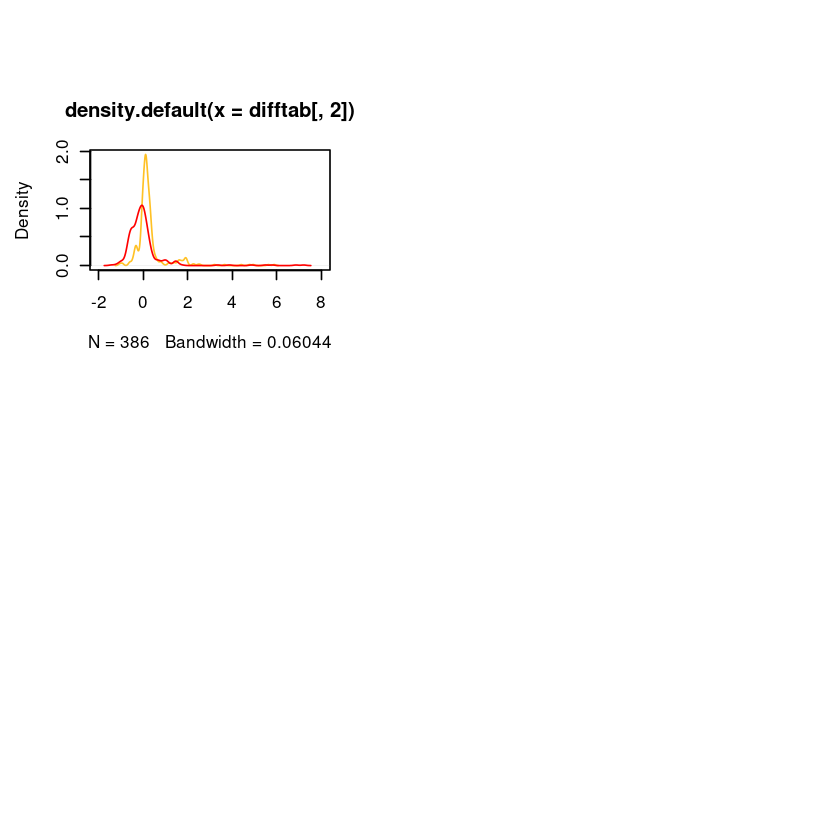

In [464]:
#pdf("/nfs/lab/projects/islet_cytok/analysis/cytokine_figures/densityeffects_beta_alpha.pdf")
par(pin=c(2,1), mfrow=c(2,2))
plot(density(difftab[,2]), xlim=c(-2,8), col="goldenrod1")
lines(density(difftab[,1]), col="red")
#dev.off()

In [481]:
dim(difftab)

[1] 386   6

In [417]:
difftab[rownames(top2)[1:8],2:1]

,alpha,beta
ELF5,2.221123,0.9082357
CEBPA,2.286815,0.9764704
ELF3,1.969324,0.8274188
RELA,2.553254,1.4253070
CEBPG,1.889729,0.7804930
CEBPE,1.763084,0.6679171
CEBPB,1.760893,0.6751475
REL,2.458656,1.4634549
